<a href="https://colab.research.google.com/github/AugustoCRX/bootcamp_covid/blob/main/notebooks/util/analise_de_sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bootcamp 2

## Análise de sentimento em publicações do twitter

### Sobre o modelo

O objetivo deste modelo é realizar análise de sentimento em publicações do twitter realizadas durante a pandemia do COVID-19, no período de ...

### Preparação do ambiente

Para o dataset de treino, acesse o link https://www.kaggle.com/datasets/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish?resource=download

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import nltk
nltk.download('popular')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
from string import punctuation

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Dropout, Activation, Dense, GRU
from tensorflow.keras import layers
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
np.random.seed(1)

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [2]:
dataset = pd.read_csv('/content/drive/MyDrive/Blue Edtech 1semestre/Módulo 7/IMDB Dataset SPANISH.csv')

### Entendendo os dados

In [ ]:
dataset

,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo
...,...,...,...,...,...
49995,49995,I thought this movie did a down right good job...,Pensé que esta película hizo un buen trabajo a...,positive,positivo
49996,49996,"Bad plot, bad dialogue, bad acting, idiotic di...","Mala parcela, mal diálogo, mala actuación, dir...",negative,negativo
49997,49997,I am a Catholic taught in parochial elementary...,Soy católica enseñada en escuelas primarias pa...,negative,negativo
49998,49998,I'm going to have to disagree with the previou...,Voy a tener que estar en desacuerdo con el com...,negative,negativo


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   50000 non-null  int64 
 1   review_en    50000 non-null  object
 2   review_es    50000 non-null  object
 3   sentiment    50000 non-null  object
 4   sentimiento  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


### Preparando os dados

In [3]:
# for i in range(0,50000):
#   if dataset['sentimiento'][i] == 'negativo':
#     dataset['sentimiento'][i] = 0
#   else:
#     dataset['sentimiento'][i] = 1

<ipython-input-3-6bf6403b493d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentimiento'][i] = 1
<ipython-input-3-6bf6403b493d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentimiento'][i] = 0


In [4]:
# !pip install clean-text
# from cleantext import clean

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.1 MB/s 
     |████████████████████████████████| 175 kB 75.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=68a0c0e000853e031ba6fd417737e547ad3cd700962677784689ed0a2a99f1d2
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [5]:
# removendo

# dataset['review_es'] = dataset['review_es'].apply(lambda x: clean(x, no_emoji=True))

In [6]:
# tokenizando

# tt = TweetTokenizer()
# dataset['review_es'] = dataset['review_es'].apply(tt.tokenize)

In [7]:
# removendo stopwords e pontuações

# stopwords = set(stopwords.words('spanish') + list(punctuation))
# dataset['review_es'] = dataset['review_es'].apply(lambda x: ' '.join([word for word in x if word not in (stopwords)]))

In [8]:
# dataset.to_csv('dataset_limpo', index = False)

In [ ]:
# df, val = train_test_split(dataset, test_size= 0.1, random_state=101, stratify=dataset['sentimiento'])
# train, test = train_test_split(df, test_size= 0.3, random_state=101, stratify=df['sentimiento'])

In [ ]:
# val.to_csv('validacao', index = False)
# train.to_csv('treino', index = False)
# test.to_csv('teste', index = False)

### Entendendo os dados após pré processamento inicial

In [21]:
contagem = []
for i in range(0,50000):
  contagem.append(len(dataset['review_es'][i]))
dataset['contagem palavras'] = contagem

In [24]:
dataset['contagem palavras'].mean()

984.03426

In [28]:
dataset['contagem palavras'].max()

13113

In [29]:
dataset['contagem palavras'].min()

23

In [31]:
dataset['contagem palavras'].quantile(0.75)

1175.0

In [77]:
dataset['contagem palavras'].quantile(0.5)

725.0

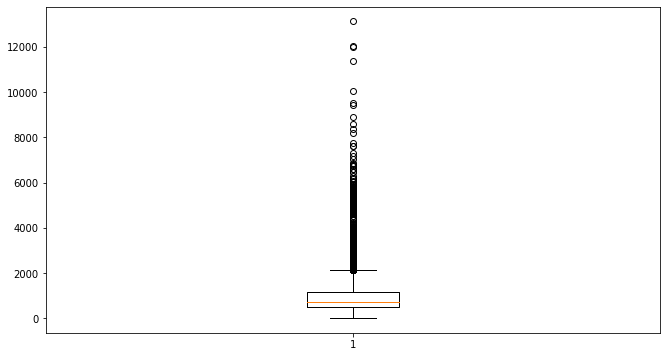

In [27]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(11, 6))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dataset['contagem palavras'],  vert = 1, patch_artist = False)

### Preparando os dados finais

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Blue Edtech 1semestre/Módulo 7/data/treino')
test = pd.read_csv('/content/drive/MyDrive/Blue Edtech 1semestre/Módulo 7/data/teste')
val = pd.read_csv('/content/drive/MyDrive/Blue Edtech 1semestre/Módulo 7/data/validacao')

In [3]:
train1 = train.head(13000)

In [4]:
print(val.shape)
print(train.shape)
print(test.shape)

(5000, 5)
(31500, 5)
(13500, 5)


In [5]:
  # TOKENIZAÇÃO
  tk = Tokenizer()

  # FIT ON TRAIN 
  tk.fit_on_texts(train1['review_es'].apply(str))

  # TOKENIZANDO O DATASET DE TREINO
  tk_train = tk.texts_to_sequences(train1['review_es'].apply(str))

  # TOKENIZANDO O DATASET DE TESTE
  tk_test = tk.texts_to_sequences(test['review_es'].apply(str))

  # TOKENIZANDO O DATASET DE VALIDAÇÃO
  tk_val = tk.texts_to_sequences(val['review_es'].apply(str))

  # COMPUTANDO O COMPRIMENTO MÁXIMO
  max_length = train['review_es'].apply(lambda x :len(str(x).split())).max()

  # COMPUTANDO O TAMANHO DO VOCABULÁRIO
  vocab_size = len(tk.word_index) + 1

  # PADDING A SEQUENCIA DE TREINO
  train_pad= pad_sequences(tk_train,padding="post",maxlen = 725)

  # PADDING A SEQUENCIA DE TESTE
  test_pad = pad_sequences(tk_test,padding = "post", maxlen = 725)

  # PADDING A SEQUENCIA DE TESTE
  val_pad = pad_sequences(tk_val,padding = "post", maxlen = 725)

In [6]:
print('vocab_size', vocab_size)
print('max_length', max_length)

vocab_size 90972
max_length 2357


In [ ]:
# # transformando array treino em dataframe

# df = pd.DataFrame({'vetores': [index for index in range(len(train_pad))]})
# df['vetores'] = df['vetores'].astype('object')
# for i in range(len(df)):
#     df.at[i,'vetores'] = train_pad[i].tolist()

# # transformando array val em dataframe

# df2 = pd.DataFrame({'vetores': [index for index in range(len(val_pad))]})
# df2['vetores'] = df2['vetores'].astype('object')
# for i in range(len(df2)):
#     df2.at[i,'vetores'] = val_pad[i].tolist()

# # transformando array teste em dataframe

# df3 = pd.DataFrame({'vetores': [index for index in range(len(test_pad))]})
# df3['vetores'] = df3['vetores'].astype('object')
# for i in range(len(df3)):
#     df3.at[i,'vetores'] = test_pad[i].tolist()

In [ ]:
# def __convert_strig_to_vector(txt):
#     txt = str(txt).replace('[', '')
#     txt = str(txt).replace(']', '')
#     txt = txt.split(',')
#     lst = [int(i) for i in txt]
#     return lst

In [ ]:
# df.vetores = df.vetores.apply(lambda x: __convert_strig_to_vector(x))
# df2.vetores = df2.vetores.apply(lambda x: __convert_strig_to_vector(x))
# df3.Vetores = df3.vetores.apply(lambda x: __convert_strig_to_vector(x))

<ipython-input-6-d2204c048312>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df3.Vetores = df3.vetores.apply(lambda x: __convert_strig_to_vector(x))


### Montando a arquitetura da rede




In [7]:
y_train = np.array(train1['sentimiento'])
y_val = np.array(val['sentimiento'])
y_test = np.array(test['sentimiento'])

In [10]:
model = Sequential()
model.add(Embedding(vocab_size, 40, input_length= 725))
model.add(Dropout(0.3))
model.add(GRU(100,return_sequences=True))
model.add(Activation('elu'))
model.add(Dense(1, activation='sigmoid'))

# SCHEDULE
def shedule(epoch,lr):
    if epoch<=2:
        return lr
    else:
        return lr*0.1

# CALLBACKS
lr = tf.keras.callbacks.LearningRateScheduler(shedule,verbose=1)
save = tf.keras.callbacks.ModelCheckpoint("content/drive/MyDrive/Blue Edtech 1semestre/Módulo 7",monitor="accuracy",mode="min",save_best_only=True, save_weights_only=True,verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor="accuracy",min_delta= 0.01, patience=2,mode="min" )

model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 725, 40)           3638880   
_________________________________________________________________
dropout_1 (Dropout)          (None, 725, 40)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 725, 100)          42300     
_________________________________________________________________
activation_1 (Activation)    (None, 725, 100)          0         
_________________________________________________________________
dense_1 (Dense)              (None, 725, 1)            101       
Total params: 3,681,281
Trainable params: 3,681,281
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
net = model.fit(train_pad, y_train, batch_size = 32, epochs= 8, validation_data = (val_pad, y_val), callbacks=[save,lr,earlystop])

Epoch 1/8

Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
407/407 [==============================] - 572s 1s/step - loss: 0.6557 - accuracy: 0.6010 - val_loss: 0.6126 - val_accuracy: 0.6772

Epoch 1: accuracy improved from inf to 0.60098, saving model to content/drive/MyDrive/Blue Edtech 1semestre/Módulo 7
Epoch 2/8

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
407/407 [==============================] - 574s 1s/step - loss: 0.4847 - accuracy: 0.7682 - val_loss: 0.4078 - val_accuracy: 0.8242

Epoch 2: accuracy did not improve from 0.60098
Epoch 3/8

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
407/407 [==============================] - 568s 1s/step - loss: 0.2109 - accuracy: 0.9210 - val_loss: 0.3858 - val_accuracy: 0.8363

Epoch 3: accuracy did not improve from 0.60098


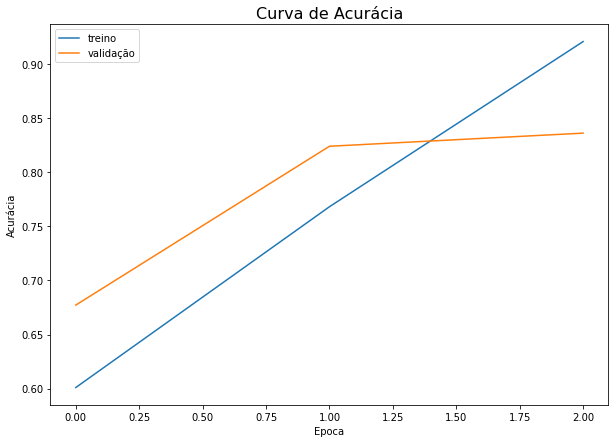

In [13]:
plt.figure(figsize = (10,7))
plt.plot(net.history['accuracy'])
plt.plot(net.history['val_accuracy'])
plt.title('Curva de Acurácia', fontsize = 16)
plt.ylabel('Acurácia')
plt.xlabel('Epoca')
plt.legend(['treino', 'validação'], loc='upper left')
plt.show()

### Avaliando o modelo

In [14]:
y_pred = model.predict(test_pad)

In [18]:
lista = []
result = pd.DataFrame()
for i in range(0,13500):
  soma = 0
  for j in range(0,725):
    soma = y_pred[i][j] + soma
  pontuacao = soma/725
  if pontuacao < 0.5:
    lista.append(0)
  else:
    lista.append(1)
result['prediction'] = lista

In [20]:
print(classification_report(test['sentimiento'], result['prediction']))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85      6750
           1       0.81      0.93      0.87      6750

    accuracy                           0.86     13500
   macro avg       0.86      0.86      0.86     13500
weighted avg       0.86      0.86      0.86     13500

